In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Google Search grounding with the Gemini API¶

New in Gemini 2.0
Gemini 2.0 Flash provides a generous Google Search quota as part of the free tier. If you switch models back to 1.5, you will need to enable billing to use Grounding with Google Search, or you can try it out in AI Studio. See the earlier versions of this notebook for guidance.

Optional: Use Google AI Studio
If you wish to try out grounding with Google Search, follow this section to try it out using the AI Studio interface. Or skip ahead to the API section to try the feature here in your notebook.

Open AI Studio

Start by going to AI Studio. You should be in the "New chat" interface.

Search Grounding is best with gemini-2.0-flash, but try out gemini-1.5-flash too.

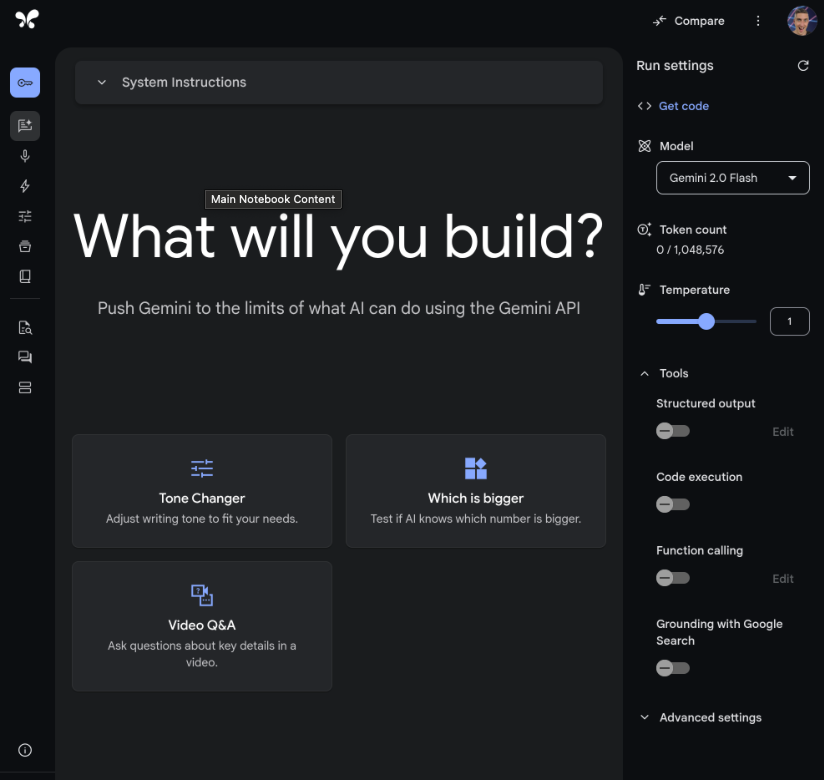

Ask a question¶

Now enter a prompt into the chat interface. Try asking something that is timely and might require recent information to answer, like a recent sport score. For this query, grounding will be disabled by default.

This screenshow shows the response for What were the top halloween costumes this year?. Every execution will be different but typically the model talks about 2023, and hedges its responses saying it doesn't have access to specific information resulting in a general comment, rather than specific answers.

In [ ]:
Enable grounding¶

On the right-hand sidebar, under the Tools section. Find and enable the Grounding option.

Enable grounding button



Try your own queries¶

Explore this interface and try some other queries. Share what works well in the Discord! You can start from this blank template that has search grounding enabled.

The remaining steps require an API key with billing enabled. They are not required to complete this course; if you have tried grounding in AI Studio you are done for this notebook.

Use the API
Start by installing and importing the Gemini API Python SDK.

In [ ]:
Use the API¶
Start by installing and importing the Gemini API Python SDK.

In [1]:
# Uninstall packages from Kaggle base image that are not needed.
!pip uninstall -qy jupyterlab jupyterlab-lsp
# Install the google-genai SDK for this codelab.
!pip install -qU 'google-genai==1.7.0'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 5.5 MB/s eta 0:00:00


In [3]:
from google import genai
from google.genai import types

from IPython.display import Markdown, HTML, display

genai.__version__

'1.7.0'

Set up your API key¶

To run the following cell, your API key must be stored it in a Kaggle secret named GOOGLE_API_KEY.

If you don't already have an API key, you can grab one from AI Studio. You can find detailed instructions in the docs.

To make the key available through Kaggle secrets, choose Secrets from the Add-ons menu and follow the instructions to add your key or enable it for this notebook.

In [4]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

client = genai.Client(api_key=GOOGLE_API_KEY)

Automated retry

In [5]:
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

Use search grounding¶
Model support

Search grounding is available in a limited set of models. Find a model that supports it on the models page.

In this guide, you'll use gemini-2.0-flash.

Make a request

To enable search grounding, you specify it as a tool: google_search. Like other tools, this is supplied as a parameter in GenerateContentConfig, and can be passed to generate_content calls as well as chats.create (for all chat turns) or chat.send_message (for specific turns).



In [6]:
# Ask for information without search grounding.
response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents="When and where is Billie Eilish's next concert?")

Markdown(response.text)

As of today, October 26, 2023, Billie Eilish does not have any concerts announced. Her last concert was October 22, 2023, at the Austin City Limits Music Festival in Austin, Texas.

Here are some tips for staying up-to-date on future Billie Eilish concerts:

*   **Check her official website:** The most reliable source of information will always be Billie Eilish's official website. Look for a "Tour" or "Events" section.
*   **Follow her social media:** Follow her on platforms like Instagram, Twitter, and Facebook. She often announces tour dates there.
*   **Sign up for her mailing list:** Her website likely has a mailing list you can subscribe to. This is a good way to get announcements directly in your email.
*   **Use ticket vendor websites:** Ticketmaster, Live Nation, and other major ticket vendors often list tour dates as soon as they are announced. You can also sometimes sign up for alerts on these sites.

Now try with grounding enabled.

In [7]:
# And now re-run the same query with search grounding enabled.
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
)

def query_with_grounding():
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents="When and where is Billie Eilish's next concert?",
        config=config_with_search,
    )
    return response.candidates[0]


rc = query_with_grounding()
Markdown(rc.content.parts[0].text)

Billie Eilish's next concert is on **Wednesday, April 23, 2025, at the Avicii Arena in Stockholm, Sweden.**


Response metadata¶

When search grounding is used, the model returns extra metadata that includes links to search suggestions, supporting documents and information on how the supporting documents were used.

Each "grounding chunk" represents information retrieved from Google Search that was used in the grounded generation request. Following the URI will take you to the source.

In [8]:
while not rc.grounding_metadata.grounding_supports or not rc.grounding_metadata.grounding_chunks:
    # If incomplete grounding data was returned, retry.
    rc = query_with_grounding()

chunks = rc.grounding_metadata.grounding_chunks
for chunk in chunks:
    print(f'{chunk.web.title}: {chunk.web.uri}')

ticketmaster.co.uk: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAK1-24__LguLE4mZZ8Di2bnCUe8JKW05GdzAInYHBng8fW435P9zDD2wkHPbVd4kUQxCF6wzMpsgcSrxrQ742p5kPMRYyhe3a28mrqCDxVkW_BpEX3eEBPIsMn8SUj8ShnSdyLM7Ga192d1G7FjN3ZlSkldHOkAXISovrMkU58=
ticketmaster.com: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJzBUdXUORiom9f2SkmJfIl3_4Hzhhro45gDmhH08QLdtBzhaYQOxAhFigTuuRNvy8MGHx8_s-s_CISnIea_DPv2rwttnQWq8umXn6t9FnR3zzQAGJipikJvanoF-dT3g-DEEi3bmrxHGS3IS2zlzbK3sfhTmCbjZ_gTQN_
wikipedia.org: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAL_PLmmNlIgMUV4GVQOwyYkUVMnlPI05aFbXzZAvhFgj8d5ISOn8nYQTbfIANcwU8knWBrvqBCZcO8NkHqHPPLRTtsgYuZvolzvZrs3DzbGUkBvPXMNYXXQ5j5jxcR8nlSke0EAEYCI2C-h7kV-X0YUF3cwLyWPVQ==


As part of the response, there is a standalone styled HTML content block that you use to link back to relevant search suggestions related to the generation.

In [ ]:
HTML(rc.grounding_metadata.search_entry_point.rendered_content)

The grounding_supports in the metadata provide a way for you to correlate the grounding chunks used to the generated output text.

In [9]:
from pprint import pprint

supports = rc.grounding_metadata.grounding_supports
for support in supports:
    pprint(support.to_json_dict())

{'confidence_scores': [0.8090547, 0.8072808, 0.8814776],
 'grounding_chunk_indices': [0, 1, 2],
 'segment': {'end_index': 67,
             'text': 'Billie Eilish is currently on her "Hit Me Hard and Soft: '
                     'The Tour".'}}
{'confidence_scores': [0.6404365],
 'grounding_chunk_indices': [1],
 'segment': {'end_index': 152,
             'start_index': 68,
             'text': 'Her next concert is on **April 23, 2025, at the Avicii '
                     'Arena in Stockholm, Sweden.**'}}


These supports can be used to highlight text in the response, or build tables of footnotes.

In [10]:
import io

markdown_buffer = io.StringIO()

# Print the text with footnote markers.
markdown_buffer.write("Supported text:\n\n")
for support in supports:
    markdown_buffer.write(" * ")
    markdown_buffer.write(
        rc.content.parts[0].text[support.segment.start_index : support.segment.end_index]
    )

    for i in support.grounding_chunk_indices:
        chunk = chunks[i].web
        markdown_buffer.write(f"<sup>[{i+1}]</sup>")

    markdown_buffer.write("\n\n")


# And print the footnotes.
markdown_buffer.write("Citations:\n\n")
for i, chunk in enumerate(chunks, start=1):
    markdown_buffer.write(f"{i}. [{chunk.web.title}]({chunk.web.uri})\n")


Markdown(markdown_buffer.getvalue())

Supported text:

 * Billie Eilish is currently on her "Hit Me Hard and Soft: The Tour".<sup>[1]</sup><sup>[2]</sup><sup>[3]</sup>

 * Her next concert is on **April 23, 2025, at the Avicii Arena in Stockholm, Sweden.**<sup>[2]</sup>

Citations:

1. [ticketmaster.co.uk](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAK1-24__LguLE4mZZ8Di2bnCUe8JKW05GdzAInYHBng8fW435P9zDD2wkHPbVd4kUQxCF6wzMpsgcSrxrQ742p5kPMRYyhe3a28mrqCDxVkW_BpEX3eEBPIsMn8SUj8ShnSdyLM7Ga192d1G7FjN3ZlSkldHOkAXISovrMkU58=)
2. [ticketmaster.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJzBUdXUORiom9f2SkmJfIl3_4Hzhhro45gDmhH08QLdtBzhaYQOxAhFigTuuRNvy8MGHx8_s-s_CISnIea_DPv2rwttnQWq8umXn6t9FnR3zzQAGJipikJvanoF-dT3g-DEEi3bmrxHGS3IS2zlzbK3sfhTmCbjZ_gTQN_)
3. [wikipedia.org](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAL_PLmmNlIgMUV4GVQOwyYkUVMnlPI05aFbXzZAvhFgj8d5ISOn8nYQTbfIANcwU8knWBrvqBCZcO8NkHqHPPLRTtsgYuZvolzvZrs3DzbGUkBvPXMNYXXQ5j5jxcR8nlSke0EAEYCI2C-h7kV-X0YUF3cwLyWPVQ==)


Search with tools¶
In this example, you'll use enable the Google Search grounding tool and the code generation tool across two steps. In the first step, the model will use Google Search to find the requested information and then in the follow-up question, it generates code to plot the results.

This usage includes textual, visual and code parts, so first define a function to help visualise these.

In [11]:
from IPython.display import display, Image, Markdown

def show_response(response):
    for p in response.candidates[0].content.parts:
        if p.text:
            display(Markdown(p.text))
        elif p.inline_data:
            display(Image(p.inline_data.data))
        else:
            print(p.to_json_dict())
    
        display(Markdown('----'))

Now start a chat asking for some information. Here you provide the Google Search tool so that the model can look up data from Google's Search index.

In [12]:
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
    temperature=0.0,
)

chat = client.chats.create(model='gemini-2.0-flash')

response = chat.send_message(
    message="What were the medal tallies, by top-10 countries, for the 2024 olympics?",
    config=config_with_search,
)

show_response(response)

Here are the top 10 countries by medal tally at the 2024 Paris Olympics:

1.  United States: 40 Gold, 44 Silver, 42 Bronze (126 total)
2.  China: 40 Gold, 27 Silver, 24 Bronze (91 total)
3.  Japan: 20 Gold, 12 Silver, 13 Bronze (45 total)
4.  Australia: 18 Gold, 19 Silver, 16 Bronze (53 total)
5.  France: 16 Gold, 26 Silver, 22 Bronze (64 total)
6.  Netherlands: 15 Gold, 7 Silver, 12 Bronze (34 total)
7.  Great Britain: 14 Gold, 22 Silver, 29 Bronze (65 total)
8.  Republic of Korea: 13 Gold, 9 Silver, 10 Bronze (32 total)
9.  Italy: 12 Gold, 13 Silver, 15 Bronze (40 total)
10. Germany: 12 Gold, 13 Silver, 8 Bronze (33 total)

----

Continuing the chat, now ask the model to convert the data into a chart. The code_execution tool is able to generate code to draw charts, execute that code and return the image. You can see the executed code in the executable_code part of the response.

Combining results from Google Search with tools like live plotting can enable very powerful use cases that require very little code to run.

Okay, I can help you visualize this data using a seaborn chart. I'll use a stacked bar chart to represent the medal distribution for each country.



----

{'executable_code': {'code': 'import pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Data from the previous response\ndata = {\n    \'Country\': [\'United States\', \'China\', \'Japan\', \'Australia\', \'France\', \'Netherlands\', \'Great Britain\', \'Republic of Korea\', \'Italy\', \'Germany\'],\n    \'Gold\': [40, 40, 20, 18, 16, 15, 14, 13, 12, 12],\n    \'Silver\': [44, 27, 12, 19, 26, 7, 22, 9, 13, 13],\n    \'Bronze\': [42, 24, 13, 16, 22, 12, 29, 10, 15, 8]\n}\n\ndf = pd.DataFrame(data)\ndf = df.set_index(\'Country\')\n\n# Plotting the stacked bar chart\nplt.figure(figsize=(12, 8))  # Adjust figure size for better readability\nsns.set_palette("viridis")  # Choose a color palette\ndf.plot(kind=\'bar\', stacked=True)\n\nplt.title(\'2024 Olympics Medal Tally (Top 10 Countries)\')\nplt.xlabel(\'Country\')\nplt.ylabel(\'Number of Medals\')\nplt.xticks(rotation=45, ha=\'right\')  # Rotate x-axis labels for readability\nplt.legend(title=\'Medal Type\')\nplt.ti

----

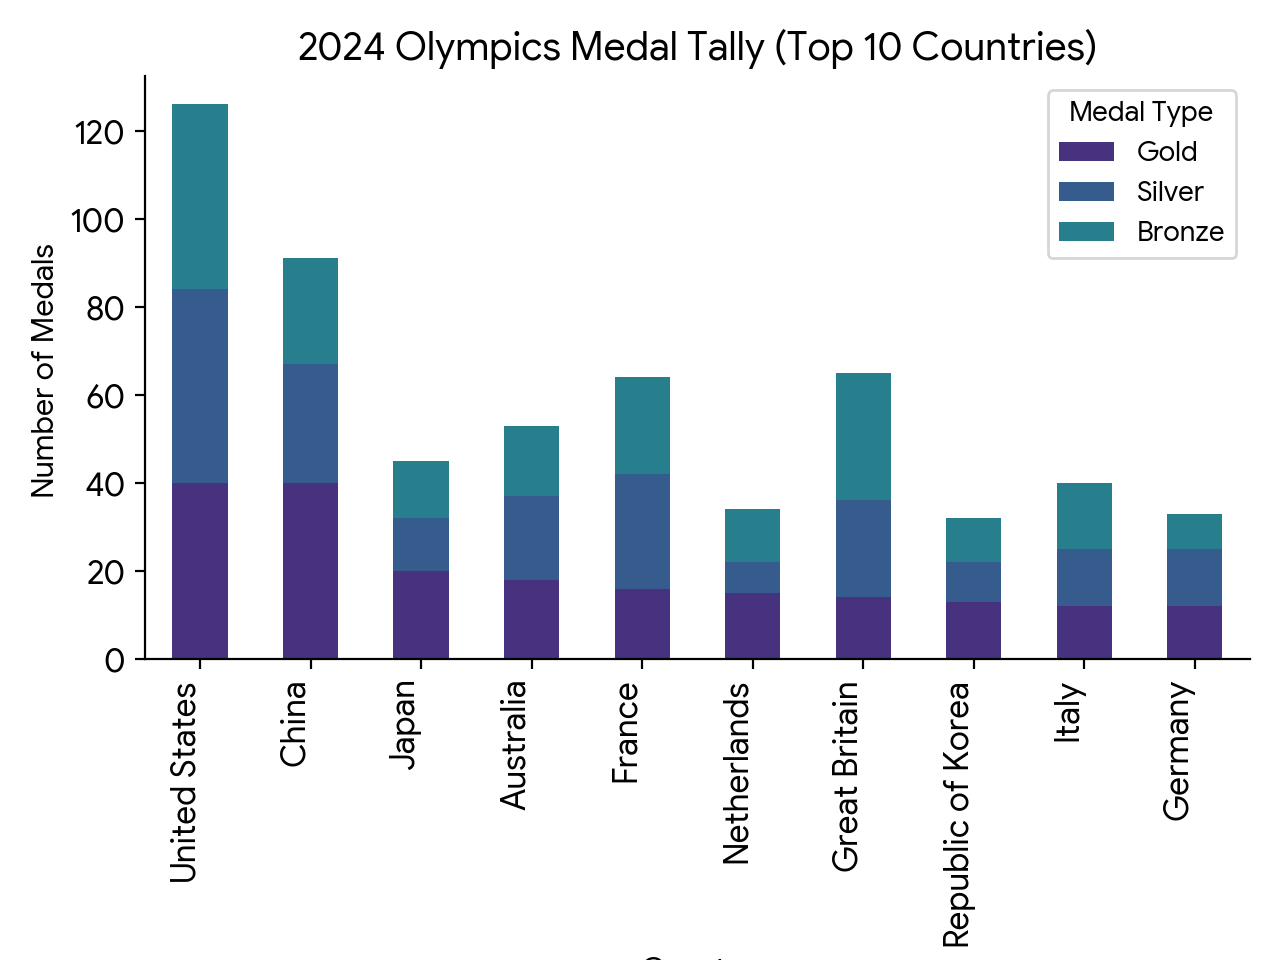

----

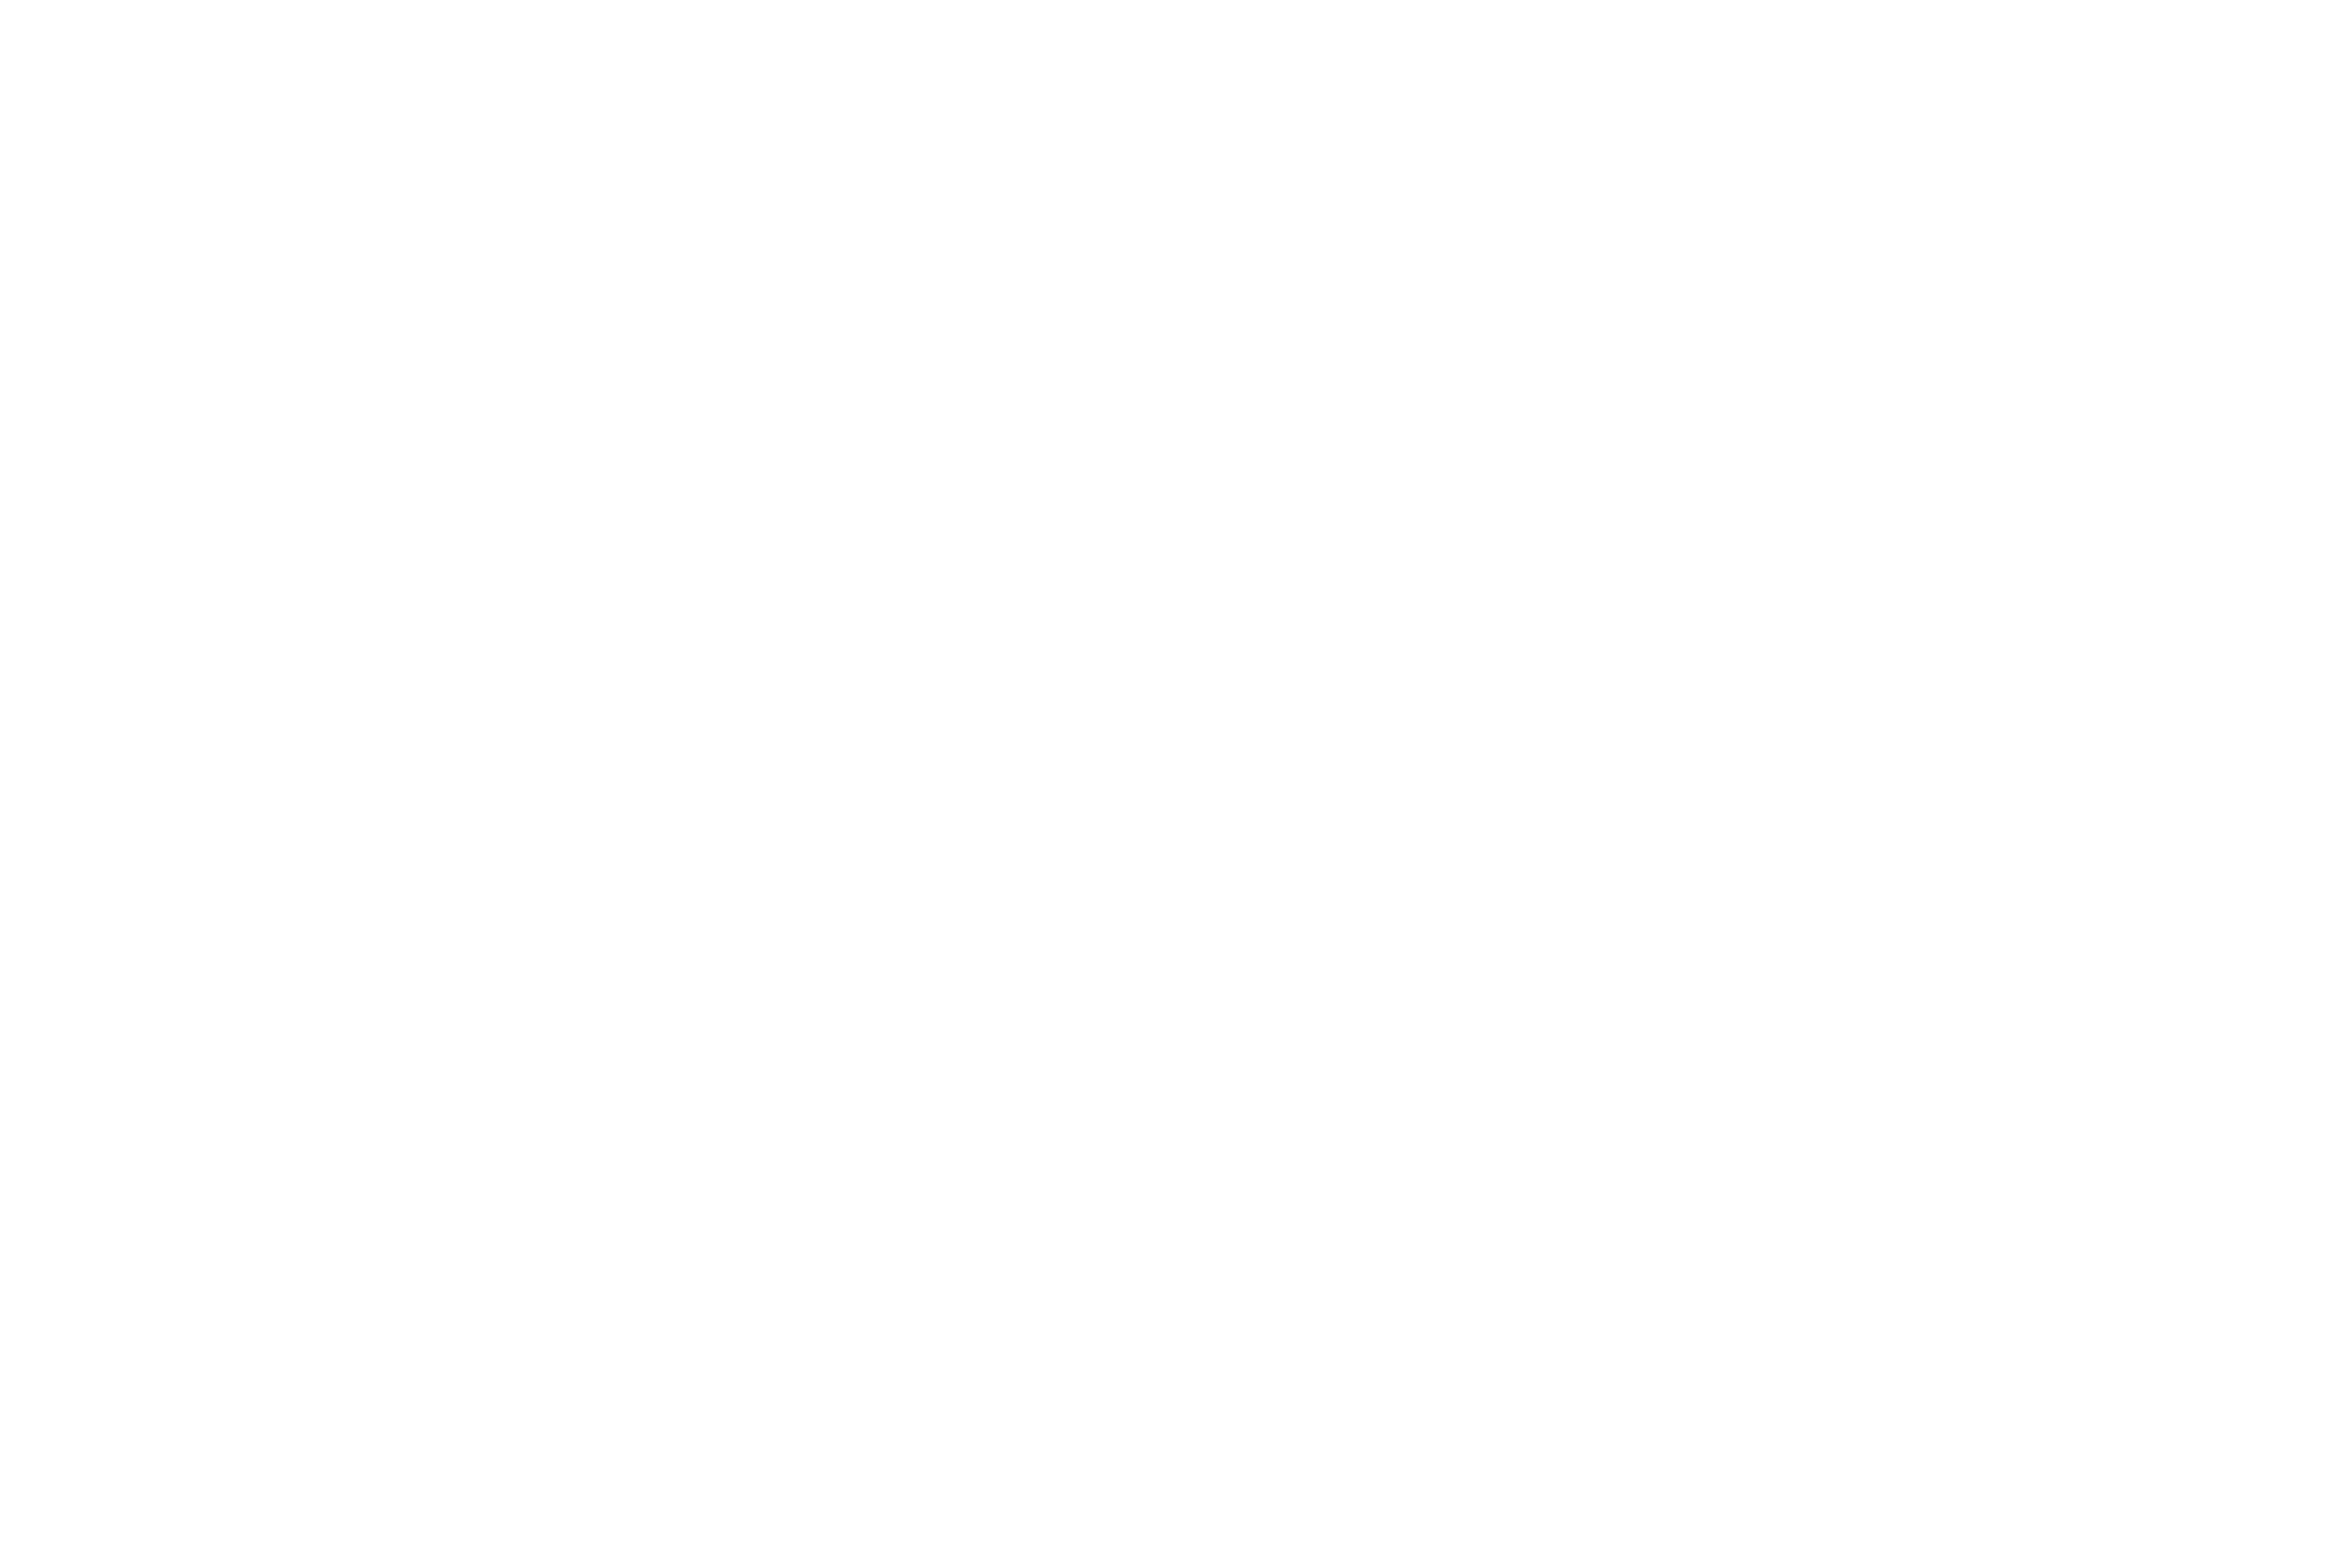

----

The stacked bar chart visually represents the medal distribution for the top 10 countries at the 2024 Olympics. Each country has a bar, and the bar is divided into segments representing the number of Gold, Silver, and Bronze medals won. This allows for easy comparison of the total medal count and the composition of medals for each country.


----

In [13]:
config_with_code = types.GenerateContentConfig(
    tools=[types.Tool(code_execution=types.ToolCodeExecution())],
    temperature=0.0,
)

response = chat.send_message(
    message="Now plot this as a seaborn chart. Break out the medals too.",
    config=config_with_code,
)

show_response(response)